I'm getting a little bored of this project, so i'll add a brief analysis of the original 230k posts i pulled from the pushshift API. My original goal was to see if bot activity increased or decreased around the time of Russia's invasion of Ukraine then quickly got out of hand when i realized making a model to predict bots was going to be difficult. I pulled all reddit posts from 2/1/2022 through 5/2/2022 from the following subreddits:

In [1]:
import psycopg2
conn = psycopg2.connect(dbname='reddit-db', user="postgres", host='localhost', password='password', port='5432')
cur = conn.cursor()

get_subreddit_info_sql = """
select subreddit, count(*) as "Number of Posts"
from 
	(select split_part(permalink, '/',3) as subreddit 
 	from posts) as sub
group by subreddit
order by subreddit asc
"""
cur.execute(get_subreddit_info_sql)
subreddit_summary = cur.fetchall()
subreddit_names = []
subreddit_post_count =  []
for i in subreddit_summary:
    subreddit_names.append(i[0])
    subreddit_post_count.append(i[1])

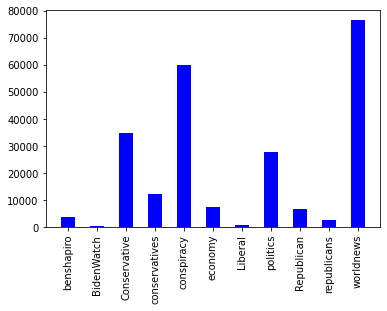

In [2]:
import matplotlib.pyplot as plt
plt.bar(subreddit_names, subreddit_post_count, width=0.5, color='blue')
plt.xticks(rotation=90)
plt.show()

r/WorldNews represents the most posts, followed by r/conspiracy, then r/Conservative. I wanted to get multiple political points, but reddit is inherently more libreral of a platform. It's safe to assume worldnews & r/politics generally have more liberal posts, which is why there is so little activity in r/Liberal when compared to r/Conservative.

Using the "Post" model for troll classification, we'll look at what percentage each subreddit has. The following code pulls all of the posts in our DB, tokenizes & vectorzes every word in the title, then runs the results through a random forest classifier:

In [3]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pickle
stop = set(stopwords.words('english'))
with open('clf_v2.pkl', 'rb') as f:
    clf = pickle.load(f)
with open('features_weights.pkl', 'rb') as f:
    feature_weight_list = pickle.load(f)
cv = CountVectorizer(stop_words=stop, max_df=0.5, min_df=1, lowercase=False, ngram_range=(1,1), strip_accents='ascii', vocabulary=feature_weight_list)

In [4]:
all_posts_and_subreddits_sql = """
select title, subreddit
from (
	select title, split_part(permalink, '/', 3) as subreddit
	from posts) as subQ
"""
cur.execute(all_posts_and_subreddits_sql)
all_posts_with_subreddits = cur.fetchall()
all_posts_posts = []
all_posts_subreddits = []
for i in all_posts_with_subreddits:
    all_posts_posts.append(i[0])
    all_posts_subreddits.append(i[1])

In [5]:
def get_vector_df(posts, cv):
    word_count_vector = cv.fit_transform(posts)
    tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    tfidf_vector = tfidf_transformer.transform(word_count_vector)
    feature_names = cv.get_feature_names_out()
    df = pd.DataFrame(tfidf_vector.toarray(), columns=feature_names)
    return df

In [6]:
predictions = clf.predict(get_vector_df(all_posts_posts, cv))

In [7]:
df_predictions_and_subreddits = pd.DataFrame({'Subreddit': all_posts_subreddits, 'Prediction': predictions})
df_predictions_and_subreddits_grouped_by_sub = df_predictions_and_subreddits.groupby('Subreddit', as_index=False).agg({'Prediction': 'mean'})
df_predictions_and_subreddits_grouped_by_sub.sort_values(by='Prediction', ascending=False, inplace=True)

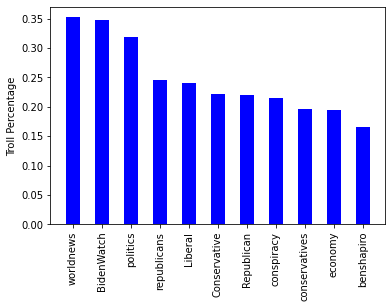

In [8]:
plt.bar(df_predictions_and_subreddits_grouped_by_sub['Subreddit'], df_predictions_and_subreddits_grouped_by_sub['Prediction'], width=0.5, color='blue')
plt.xticks(rotation=90)
plt.ylabel('Troll Percentage')
plt.show()

Here we see a general trend in the larger subreddits having the highest percentage of posts classified as "Troll" content, while somre more niche subreddits are a little lower. Lets look at the data over time.

In [9]:
times = []
time_sql = """
select created from posts
"""
cur.execute(time_sql)
all_times = cur.fetchall()
for i in all_times:
    times.append(i[0])
df_predictions_and_subreddits['created_unix'] = times

In [10]:
import datetime
def unix_to_date(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp).strftime('%Y-%m-%d')
df_predictions_and_subreddits['created_date'] = df_predictions_and_subreddits['created_unix'].apply(unix_to_date)
df_predictions_and_subreddits.head()

,Subreddit,Prediction,created_unix,created_date
0,benshapiro,0,1643692642,2022-02-01
1,benshapiro,0,1643694926,2022-02-01
2,benshapiro,0,1643698588,2022-02-01
3,benshapiro,0,1643721306,2022-02-01
4,benshapiro,1,1643722224,2022-02-01


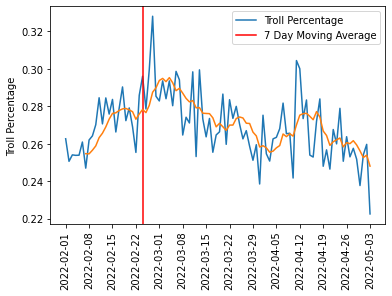

In [11]:
df_predictions_and_subreddits_groupby_date = df_predictions_and_subreddits.groupby('created_date', as_index=False).agg({'Prediction': 'mean'})
plt.plot(df_predictions_and_subreddits_groupby_date['created_date'], df_predictions_and_subreddits_groupby_date['Prediction'])
plt.ylabel('Troll Percentage')
plt.xticks(df_predictions_and_subreddits_groupby_date['created_date'][::7], rotation=90)
plt.axvline(x='2022-02-24', color='r')
plt.plot(df_predictions_and_subreddits_groupby_date['created_date'], df_predictions_and_subreddits_groupby_date['Prediction'].rolling(7).mean())
plt.legend(['Troll Percentage', '7 Day Moving Average'])
plt.show()

The vertical red line shows when Russia invaded Ukraine (Feb 24), and we can see from the moving average that there is a downward trend occuring about a week afterward.

It looks like there's another increase in activity around April 12. Although I'm not sure what the conversation was. We'll do some NLP on the date range 4-11 through 4-20 next:

In [12]:
def date_to_unix(date):
    return int(datetime.datetime.strptime(date, '%Y-%m-%d').timestamp())
start_date_unix = date_to_unix('2022-04-11')
end_date_unix = date_to_unix('2022-04-21')

In [13]:
specific_time_sql = """
select string_agg(title, ',') from posts where created >= %s and created <= %s and author not like 'HovercraftNo1808'
"""
cur.execute(specific_time_sql, (start_date_unix, end_date_unix))
posts_within_range_response = cur.fetchall()
posts_within_range_list = []
for i in posts_within_range_response:
    posts_within_range_list.append(str(i[0]))

In [14]:
from nltk.tokenize import word_tokenize
def get_corpus(source_list):
    corpus = []
    for i in source_list:
        words = word_tokenize(i)
        corpus.append(' '.join([w for w in words if w not in stop]))
    return corpus
corpus = get_corpus(posts_within_range_list)

In [15]:
def generate_top_ngrams(corpus):
    vec = CountVectorizer(ngram_range=(4, 4))
    vec.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]
top_ngrams = generate_top_ngrams(corpus)[:10]
x,y = map(list,zip(*top_ngrams))
output = list(zip(x,y))
df_ngrams = pd.DataFrame(output, columns=['ngram', 'count'])

In [16]:
print(df_ngrams)

                         ngram  count
0         elon musk offers buy     38
1      musk offers buy twitter     36
2     sweden finland join nato     17
3         15 week abortion ban     16
4          elon musk wins deal     16
5           musk wins deal buy     16
6        wins deal buy twitter     16
7  hospital murder wef agendas     15
8       murder wef agendas the     15
9        wef agendas the enemy     15
